# Loading FER Data-set

reference : 


1) https://appliedmachinelearning.blog/2018/11/28/demonstration-of-facial-emotion-recognition-on-real-time-video-using-cnn-python-keras/

2) https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data?select=example_submission.csv

In [1]:
#!pip install opencv-python

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
!cd /content/gdrive/MyDrive/GraduationProject/Emotion_Classification

In [11]:
import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

 
train_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/train.csv'
# test_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/test.csv'

image_size=(48,48)

def load_fer2013():
    data = pd.read_csv(train_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).values
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_fer2013()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)

In [12]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np

# parameters
batch_size = 32
num_epochs = 10 #110
input_shape = (48, 48, 1)
verbose = 1
num_classes = 7
patience = 50
base_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/'
l2_regularization=0.01

# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
regularization = l2(l2_regularization)
 
# base
img_input = Input(input_shape)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(img_input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
 
# module 1
residual = Conv2D(16, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(16, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 2
residual = Conv2D(32, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(32, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 3
residual = Conv2D(64, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(64, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
 
# module 4
residual = Conv2D(128, (1, 1), strides=(2, 2),padding='same', use_bias=False)(x)
residual = BatchNormalization()(residual)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = SeparableConv2D(128, (3, 3), padding='same',kernel_regularizer=regularization,use_bias=False)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
x = layers.add([x, residual])
x = Conv2D(num_classes, (3, 3), padding='same')(x)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax',name='predictions')(x)
 
model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
# callbacks
log_file_path = base_path + '_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_mini_XCEPTION'
model_names = trained_models_path + '.{epoch:02d}-{val_loss:.2f}.hdf5'
#model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
model_checkpoint = ModelCheckpoint(model_names, 'val_accuracy', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

 
base_history = model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 46, 46, 8)    32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 46, 46, 8)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
717/717 [==============================] - 191s 263ms/step - loss: 1.9195 - accuracy: 0.2657 - val_loss: 1.6748 - val_accuracy: 0.3885

Epoch 00001: val_accuracy improved from -inf to 0.38854, saving model to /content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/_mini_XCEPTION.01-1.67.hdf5
Epoch 2/10
717/717 [==============================] - 188s 262ms/step - loss: 1.6196 - accuracy: 0.3909 - val_loss: 1.4153 - val_accuracy: 0.4702

Epoch 00002: val_accuracy improved from 0.38854 to 0.47022, saving model to /content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/_mini_XCEPTION.02-1.42.hdf5
Epoch 3/10
717/717 [==============================] - 192s 268ms/step - loss: 1.4535 - accuracy: 0.4527 - val_loss: 1.4176 - val_accuracy: 0.4842

Epoch 00003: val_accuracy improved from 0.47022 to 0.48415, saving model to /content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/_mini_XCEPTION.03-1.42.hdf5
Epoch 4/10
717/717 [==============

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def plot_history(histories, key='accuracy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    #print(history.history)
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])

2.4.1


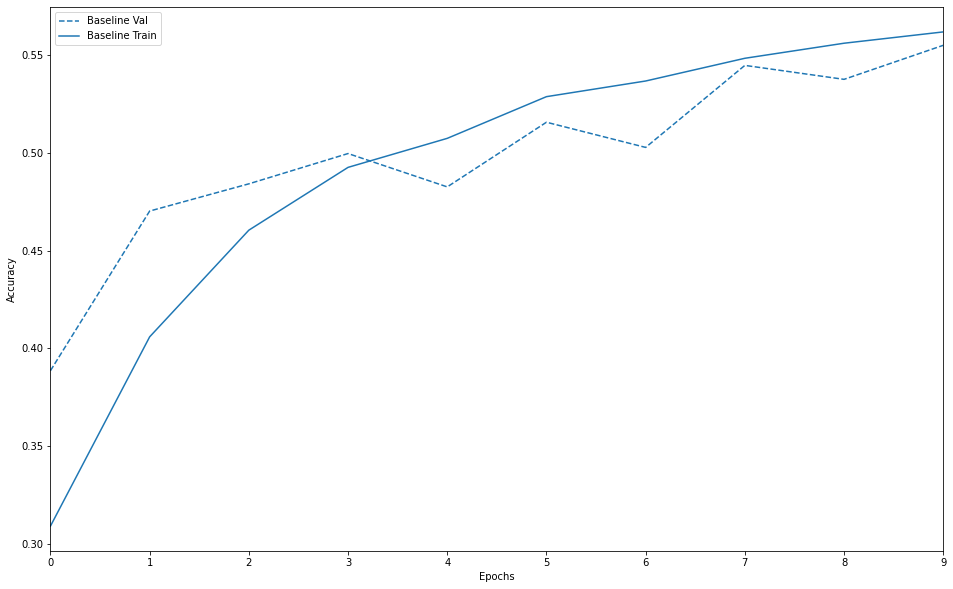

In [14]:
plot_history([('baseline', base_history)], 'accuracy')

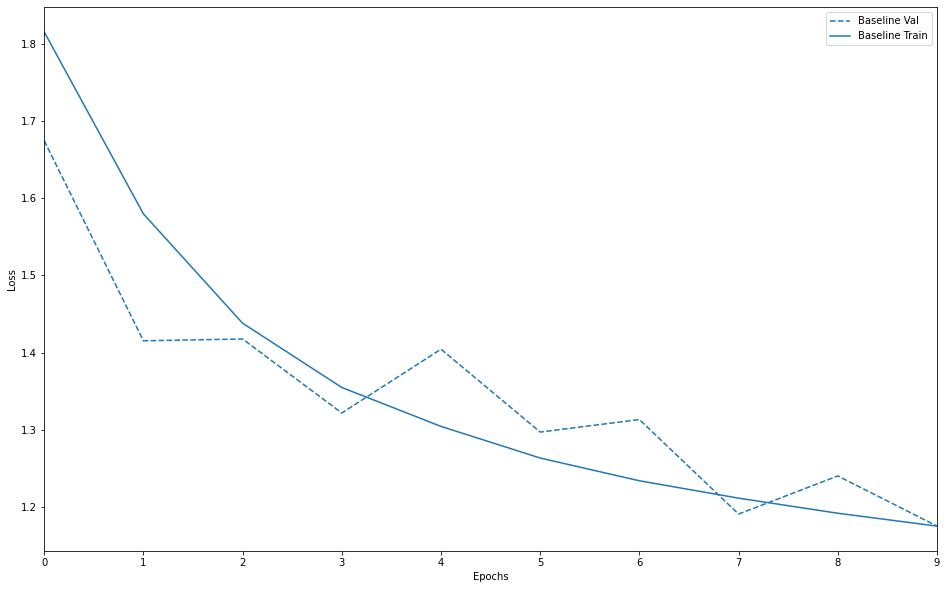

In [15]:
plot_history([('baseline', base_history)], 'loss')

In [16]:
#!pip install --upgrade --user tensorflow

In [17]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
import sys
from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/haarcascade_files/haarcascade_frontface.xml'
#emotion_model_path = '/models/_mini_XCEPTION.106-0.65.hdf5'
emotion_model_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/_mini_XCEPTION.10-1.23.hdf5'
img_path = sys.argv[1]
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
 
#reading the frame
orig_frame = cv2.imread(img_path)
print(img_path)
#print(orig_frame)
frame = cv2.imread(img_path,0)
#print(frame)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
 
#cv2.imshow('test_face', orig_frame)
cv2_imshow(orig_frame)
cv2.imwrite('test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(2000) and 0xFF == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

-f


AttributeError: ignored

In [2]:
import sys
sys.path.append('content/gdrive/MyDrive/GraduationProject/Emotion_Classification/utils')

In [3]:
import os
os.chdir('/content/gdrive/MyDrive/GraduationProject/Emotion_Classification')
os.getcwd()

'/content/gdrive/MyDrive/GraduationProject/Emotion_Classification'

In [4]:
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 'content/gdrive/MyDrive/GraduationProject/Emotion_Classification/utils']

In [5]:
!pip uninstall utils

In [6]:
!pip install scipy==1.2.1

In [ ]:
from statistics import mode

import cv2
from keras.models import load_model
import numpy as np

from utils.datasets import get_labels
from utils.inference import detect_faces
from utils.inference import draw_text
from utils.inference import draw_bounding_box
from utils.inference import apply_offsets
from utils.inference import load_detection_model
from utils.preprocessor import preprocess_input

# parameters for loading data and images
detection_model_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/haarcascade_files/haarcascade_frontface.xml'
emotion_model_path = '/content/gdrive/MyDrive/GraduationProject/Emotion_Classification/models/_mini_XCEPTION.10-1.23.hdf5'
emotion_labels = get_labels('fer2013')

# hyper-parameters for bounding boxes shape
frame_window = 10
emotion_offsets = (20, 40)

# loading models
face_detection = load_detection_model(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)

# getting input model shapes for inference
emotion_target_size = emotion_classifier.input_shape[1:3]

# starting lists for calculating modes
emotion_window = []

# starting video streaming
cv2.namedWindow('window_frame')
video_capture = cv2.VideoCapture(0)
while True:
    bgr_image = video_capture.read()[1]
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    faces = detect_faces(face_detection, gray_image)

    for face_coordinates in faces:

        x1, x2, y1, y2 = apply_offsets(face_coordinates, emotion_offsets)
        gray_face = gray_image[y1:y2, x1:x2]
        try:
            gray_face = cv2.resize(gray_face, (emotion_target_size))
        except:
            continue

        gray_face = preprocess_input(gray_face, True)
        gray_face = np.expand_dims(gray_face, 0)
        gray_face = np.expand_dims(gray_face, -1)
        emotion_prediction = emotion_classifier.predict(gray_face)
        emotion_probability = np.max(emotion_prediction)
        emotion_label_arg = np.argmax(emotion_prediction)
        emotion_text = emotion_labels[emotion_label_arg]
        emotion_window.append(emotion_text)

        if len(emotion_window) > frame_window:
            emotion_window.pop(0)
        try:
            emotion_mode = mode(emotion_window)
        except:
            continue

        if emotion_text == 'angry':
            color = emotion_probability * np.asarray((255, 0, 0))
        elif emotion_text == 'sad':
            color = emotion_probability * np.asarray((0, 0, 255))
        elif emotion_text == 'happy':
            color = emotion_probability * np.asarray((255, 255, 0))
        elif emotion_text == 'surprise':
            color = emotion_probability * np.asarray((0, 255, 255))
        else:
            color = emotion_probability * np.asarray((0, 255, 0))

        color = color.astype(int)
        color = color.tolist()

        draw_bounding_box(face_coordinates, rgb_image, color)
        draw_text(face_coordinates, rgb_image, emotion_mode,
                  color, 0, -45, 1, 1)

    bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
    cv2.imshow('window_frame', bgr_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
video_capture.release()
cv2.destroyAllWindows()